In [1]:
# Install wandb for saving training logs
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=ad595a0e99ddb8050b7920d45e53cf9a719c29a5a4f2e09ef43194d866af502f
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import os
import time
from tqdm import tqdm
import wandb
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [4]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes):
        super(GoogLeNet, self).__init__()
        
        self.conv1 = ConvBlock(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Sequential(
            ConvBlock(64, 64, kernel_size=1, stride=1, padding=0),
            ConvBlock(64, 192, kernel_size=3, stride=1, padding=1),
        )

        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)
        
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(in_features=1024, out_features=num_classes)
        
        # Initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, input):
        x = self.conv1(input)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = torch.reshape(x, (x.shape[0], -1))
        x = self.dropout(x)
        x = self.fc(x)
        
        x = F.log_softmax(x, dim=1)
        return x
    

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out1, out3red, out3, out5red, out5, out1pool):
        super(InceptionBlock, self).__init__()

        self.branch1 = ConvBlock(in_channels, out1, kernel_size=1)
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, out3red, kernel_size=1),
            ConvBlock(out3red, out3, kernel_size=3, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, out5red, kernel_size=1),
            ConvBlock(out5red, out5, kernel_size=5, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out1pool, kernel_size=1)
        )
        
    def forward(self, input):
        branch1 = self.branch1(input)
        branch2 = self.branch2(input)
        branch3 = self.branch3(input)
        branch4 = self.branch4(input)
    
        result = torch.cat((branch1, branch2, branch3, branch4), dim=1)
        return result
    
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [18]:
# Initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# training parameters
epochs = 15
batch_size = 64
learning_rate = 0.001
momentum = 0.9
weight_decay = 5*10e-4

# Declare the network
model = GoogLeNet(10).to(device)

# Loss function - Cross Entropy 
loss_fn = nn.CrossEntropyLoss().to(device)

# Optimizer - Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# .MultiStepLR(optimizer, milestones=[5,10], gamma=0.1)

In [19]:
# Construct the dataset and data loader
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)), # change mnist to 3 channels instead of 1
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip()
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.expand(3, -1, -1)), # change mnist to 3 channels instead of 1
    transforms.Normalize((0.1307, 0.1307, 0.1307), (0.3081, 0.3081, 0.3081)),
    transforms.Resize((224, 224)),
])

train_data = datasets.MNIST(root='.', train=True, download=True, transform=train_transform)
test_data = datasets.MNIST(root='.', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)


In [20]:
# Login to wandb
wandb.login()

# Initialize wandb
run = wandb.init(
    # set the wandb project where this run will be logged
    project="GoogLeNet-MNIST",
    
    # track hyperparameters and run metadata
    config={
        "architecture": "GoogLeNet",
        "dataset": "MNIST",
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "momentum": momentum,
        "written_model": "yes",
        "with relu":"yes",
        "data-augmentation":"hflip 0.5",
        "others": "dropout 0.4, steplr scheduler 10, 0.1 gamma. batch norm weight init",
        "optimizer": "sgd",
        "log_softmax": "yes",
        "weight_decay": weight_decay,
    }
)

# Keep track of training and test loss
total_loss = [[], [], []]


In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = []

    for (images, labels) in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Compute prediction and loss
        pred = model(images)
        loss = loss_fn(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

    epoch_loss = np.mean(running_loss)
    print(f'loss: {epoch_loss:.3f}')
    return epoch_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct, correct_5 = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
            
            # Calculate top-5 accuracy
            _, pred_5 = pred.topk(5)

            for i in range(len(labels)):
                if labels[i] in pred_5[i]:
                    correct_5 += 1


    test_loss /= num_batches
    correct /= size
    correct_5/=size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Top-5 Accuracy: {(100*correct_5):>0.1f}%, \n Loss: {test_loss:>8f} \n")
    
    return test_loss, correct*100, correct_5*100

In [ ]:
print("Starting Training Loop...")
start_time = time.time()

for t in range(epochs):
    epoch_start_time = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    
    epoch_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, top1_accuracy, top5_accuracy = test_loop(test_dataloader, model, loss_fn)
    
    total_loss[0].append(t+1)
    total_loss[1].append(epoch_loss)
    total_loss[2].append(test_loss)
    
    wandb.log({ "training_loss": epoch_loss, "test_loss": test_loss, "acc": top1_accuracy, "top5_accuracy": top5_accuracy })

    print("current lr", scheduler.get_last_lr())
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    print("Epoch %d of %d with %.2f s" % (t + 1, epochs, per_epoch_ptime))


print("Done!")
end_time = time.time()
total_ptime = end_time - start_time
print("Total time %.2f" % (total_ptime))

Starting Training Loop...
Epoch 1
-------------------------------


100%|██████████| 938/938 [02:50<00:00,  5.49it/s]


loss: 0.422
Test Error: 
 Accuracy: 95.8%, Top-5 Accuracy: 99.9%, 
 Loss: 0.135816 

current lr [0.001]
Epoch 1 of 15 with 190.09 s
Epoch 2
-------------------------------


100%|██████████| 938/938 [02:51<00:00,  5.48it/s]


loss: 0.100
Test Error: 
 Accuracy: 97.3%, Top-5 Accuracy: 100.0%, 
 Loss: 0.090657 

current lr [0.001]
Epoch 2 of 15 with 189.95 s
Epoch 3
-------------------------------


100%|██████████| 938/938 [02:50<00:00,  5.49it/s]


loss: 0.072
Test Error: 
 Accuracy: 97.4%, Top-5 Accuracy: 100.0%, 
 Loss: 0.085506 

current lr [0.001]
Epoch 3 of 15 with 189.49 s
Epoch 4
-------------------------------


100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


loss: 0.056
Test Error: 
 Accuracy: 98.0%, Top-5 Accuracy: 100.0%, 
 Loss: 0.069450 

current lr [0.001]
Epoch 4 of 15 with 189.40 s
Epoch 5
-------------------------------


100%|██████████| 938/938 [02:50<00:00,  5.52it/s]


loss: 0.049
Test Error: 
 Accuracy: 97.9%, Top-5 Accuracy: 100.0%, 
 Loss: 0.065828 

current lr [0.001]
Epoch 5 of 15 with 189.21 s
Epoch 6
-------------------------------


100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


loss: 0.043
Test Error: 
 Accuracy: 98.3%, Top-5 Accuracy: 100.0%, 
 Loss: 0.062203 

current lr [0.001]
Epoch 6 of 15 with 189.17 s
Epoch 7
-------------------------------


100%|██████████| 938/938 [02:50<00:00,  5.50it/s]


loss: 0.040
Test Error: 
 Accuracy: 98.1%, Top-5 Accuracy: 100.0%, 
 Loss: 0.063916 

current lr [0.001]
Epoch 7 of 15 with 189.11 s
Epoch 8
-------------------------------


100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


loss: 0.037
Test Error: 
 Accuracy: 98.3%, Top-5 Accuracy: 100.0%, 
 Loss: 0.056561 

current lr [0.001]
Epoch 8 of 15 with 189.65 s
Epoch 9
-------------------------------


100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


loss: 0.034
Test Error: 
 Accuracy: 98.5%, Top-5 Accuracy: 100.0%, 
 Loss: 0.050591 

current lr [0.001]
Epoch 9 of 15 with 189.40 s
Epoch 10
-------------------------------


100%|██████████| 938/938 [02:49<00:00,  5.52it/s]


loss: 0.031
Test Error: 
 Accuracy: 98.4%, Top-5 Accuracy: 100.0%, 
 Loss: 0.051939 

current lr [0.001]
Epoch 10 of 15 with 188.86 s
Epoch 11
-------------------------------


100%|██████████| 938/938 [02:49<00:00,  5.53it/s]


loss: 0.032
Test Error: 
 Accuracy: 98.5%, Top-5 Accuracy: 100.0%, 
 Loss: 0.050682 

current lr [0.001]
Epoch 11 of 15 with 188.45 s
Epoch 12
-------------------------------


100%|██████████| 938/938 [02:49<00:00,  5.53it/s]


loss: 0.029
Test Error: 
 Accuracy: 98.3%, Top-5 Accuracy: 100.0%, 
 Loss: 0.059533 

current lr [0.001]
Epoch 12 of 15 with 188.63 s
Epoch 13
-------------------------------


100%|██████████| 938/938 [02:49<00:00,  5.53it/s]


loss: 0.028
Test Error: 
 Accuracy: 98.2%, Top-5 Accuracy: 100.0%, 
 Loss: 0.058219 

current lr [0.001]
Epoch 13 of 15 with 188.21 s
Epoch 14
-------------------------------


100%|██████████| 938/938 [02:50<00:00,  5.51it/s]


loss: 0.029
Test Error: 
 Accuracy: 98.3%, Top-5 Accuracy: 100.0%, 
 Loss: 0.059972 

current lr [0.001]
Epoch 14 of 15 with 188.96 s
Epoch 15
-------------------------------


 57%|█████▋    | 534/938 [01:36<01:24,  4.80it/s]

In [ ]:
test_loop(test_dataloader, model, loss_fn)

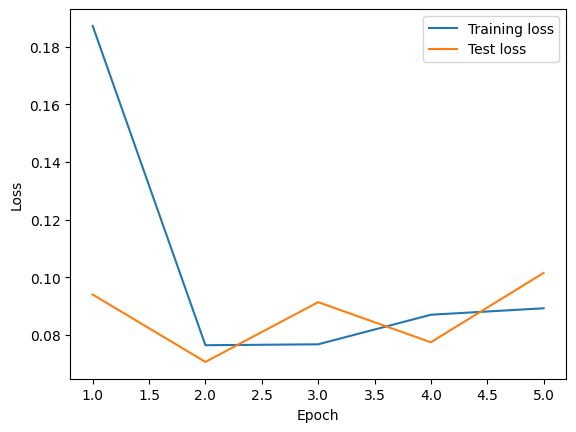

In [17]:
plt.plot(total_loss[0], total_loss[1], label = "Training loss")
plt.plot(total_loss[0], total_loss[2], label = "Test loss")

# Add labels and title to the plot
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [16]:
# Close wandb run
run.finish()

acc,▁▇▄█▃
test_loss,▆▁▆▃█
top5_accuracy,▁▆█▃▁
training_loss,█▁▁▂▂
acc,97.43
test_loss,0.10154
top5_accuracy,99.95
training_loss,0.08927


In [ ]:
# Save model
torch.save(model, 'googlenet_mnist_trained_model.pth')